Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../../src/")

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [5]:
df_feats = pd.read_parquet("../../features/sleep-edf__telemetry_features_ALL__90s.parquet")
df_feats.shape

(42839, 366)

In [6]:
df_feats["label"].value_counts()

Sleep stage 2    19851
Sleep stage R     8349
Sleep stage W     4488
Sleep stage 1     3653
Sleep stage 3     3398
Sleep stage 4     3017
Movement time       83
Name: label, dtype: int64

In [7]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m30s_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 60.6+ MB


In [8]:
sigs = list(set(c.split("__")[0] for c in df_feats.columns))
eeg_signals = [d for d in sigs if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(42839, 396)

In [9]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [10]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(42839, 1051)

In [11]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 1051 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to EEG Fpz-Cz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(1048), object(3)
memory usage: 172.6+ MB


In [12]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [13]:
df_feats.shape

(42756, 1051)

In [14]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]
len(feat_cols)

1048

In [15]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

# ML

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [17]:
from visualizations import plot_linear_classification_coefs
from visualizations import plot_learning_curve
from visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [18]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 22-fold results for all the data for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.8075
  Balanced accuracy:  0.8134
  Accuracy:           0.8454
  Log loss:           0.6325
10-FOLD: TEST
  MACRO F1:           0.7444
  Balanced accuracy:  0.7673
  Accuracy:           0.8031
  Log loss:           0.9078

F1: 0.7581570179191433
ACC: 0.8024370848535878
KAPPA: 0.722717077565202
LOG LOSS: 0.9102606738583787

               precision    recall  f1-score   support

Sleep stage 1       0.50      0.48      0.49      3856
Sleep stage 2       0.83      0.87      0.85     19006
Sleep stage 3       0.84      0.76      0.80      7096
Sleep stage R       0.80      0.83      0.82      8093
Sleep stage W       0.86      0.82      0.84      4705

     accuracy                           0.80     42756
    macro avg       0.77      0.75      0.76     42756
 weighted avg       0.80      0.80      0.80     42756



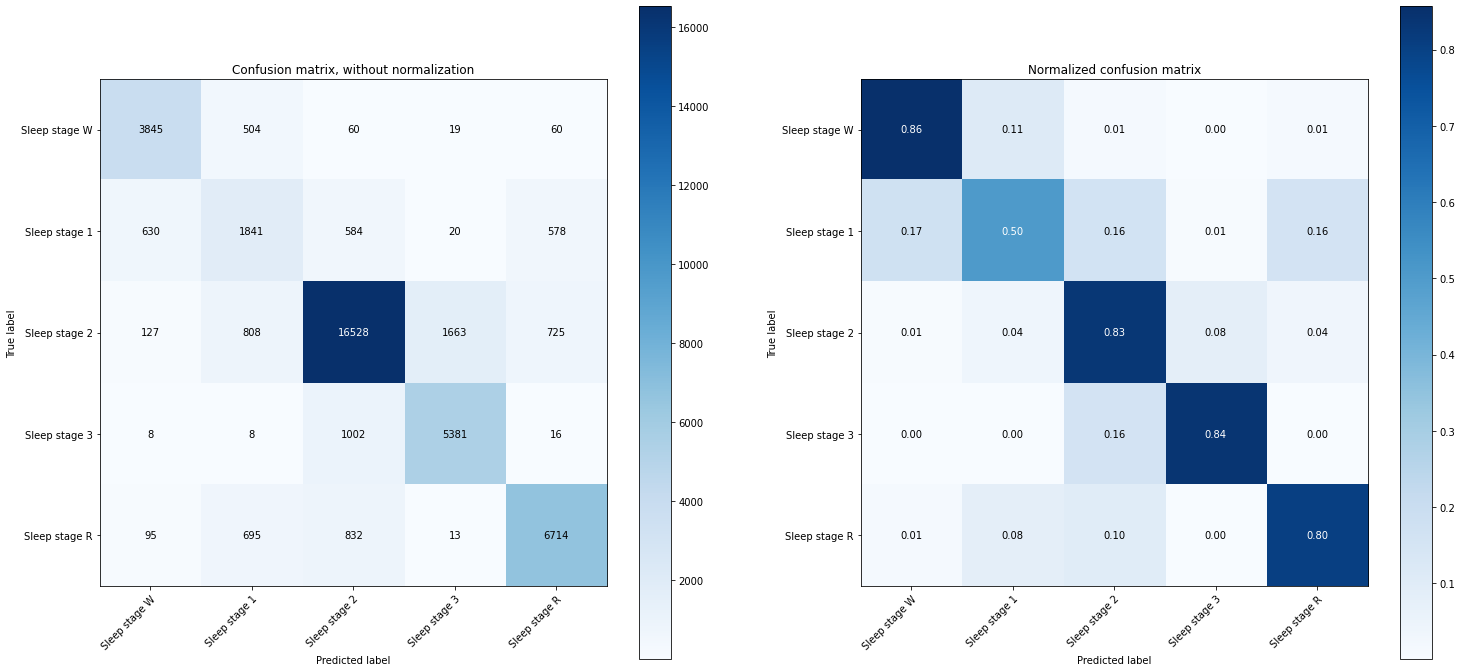





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.8357
  Balanced accuracy:  0.8403
  Accuracy:           0.8655
  Log loss:           0.6316
10-FOLD: TEST
  MACRO F1:           0.7741
  Balanced accuracy:  0.7977
  Accuracy:           0.8256
  Log loss:           0.992

F1: 0.7875482089872873
ACC: 0.8254747871643746
KAPPA: 0.7536410551929347
LOG LOSS: 0.9934759749493883

               precision    recall  f1-score   support

Sleep stage 1       0.57      0.56      0.56      3738
Sleep stage 2       0.85      0.87      0.86     19539
Sleep stage 3       0.84      0.78      0.81      6890
Sleep stage R       0.85      0.88      0.86      7980
Sleep stage W       0.85      0.83      0.84      4609

     accuracy                           0.83     42756
    macro avg       0.79      0.78      0.79     42756
 weighted avg       0.82      0.83      0.82     42756



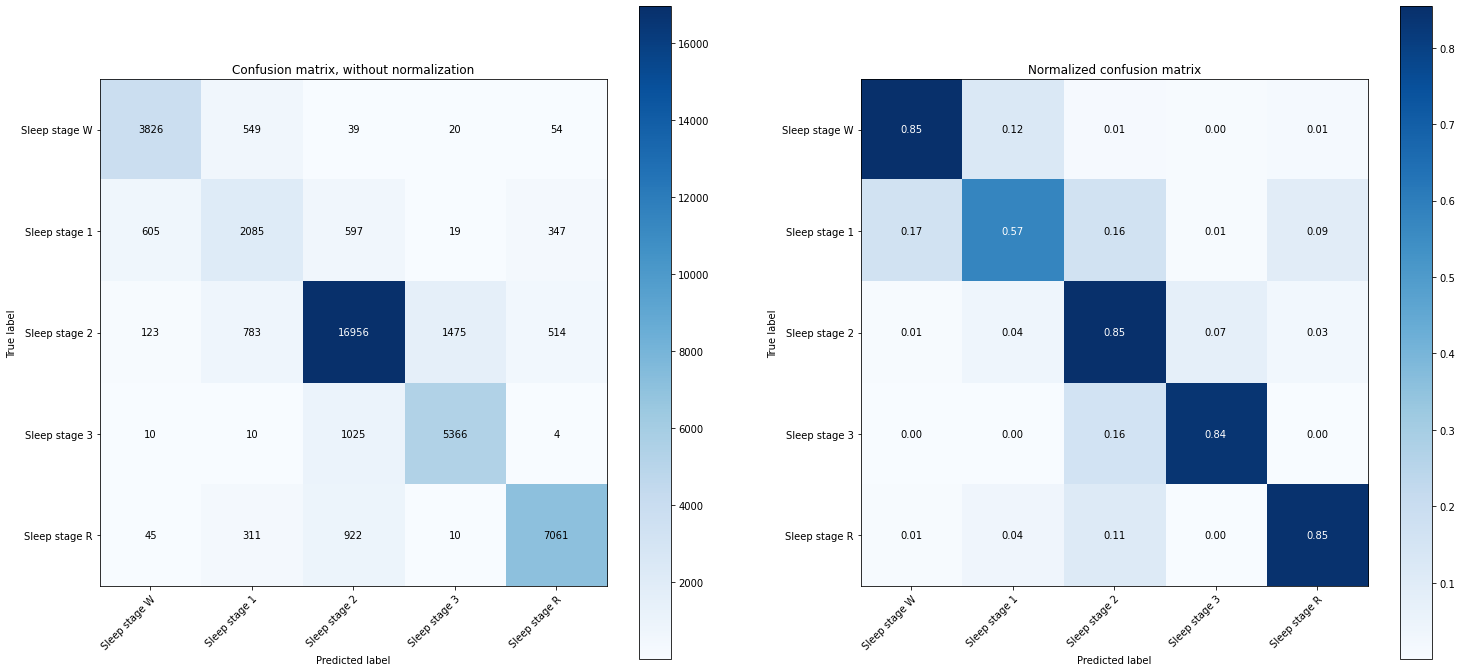





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.8244
  Balanced accuracy:  0.8307
  Accuracy:           0.8577
  Log loss:           0.6101
10-FOLD: TEST
  MACRO F1:           0.7634
  Balanced accuracy:  0.7922
  Accuracy:           0.816
  Log loss:           0.9343

F1: 0.7761449052258811
ACC: 0.8159322668163532
KAPPA: 0.7414684468446058
LOG LOSS: 0.9364809555460304

               precision    recall  f1-score   support

Sleep stage 1       0.53      0.53      0.53      3658
Sleep stage 2       0.83      0.87      0.85     18975
Sleep stage 3       0.84      0.77      0.80      6983
Sleep stage R       0.86      0.85      0.86      8477
Sleep stage W       0.86      0.82      0.84      4663

     accuracy                           0.82     42756
    macro avg       0.78      0.77      0.78     42756
 weighted avg       0.82      0.82      0.82     42756



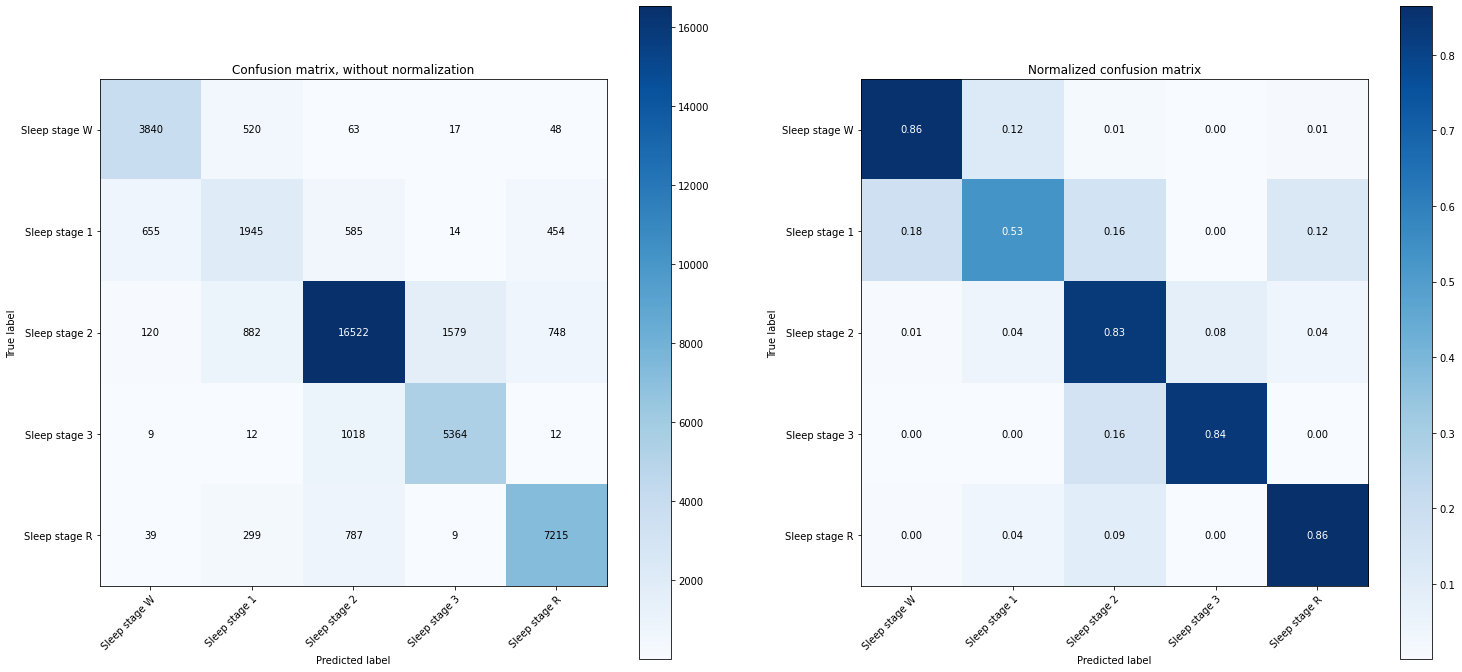

In [19]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=22)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test)]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")

## The simple, catboost pipeline

In [20]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

### Grouped 22-fold results for all the data for varying inputs

---------------------------------------- ['EEG'] ----------------------------------------
nb. features = 592
10-FOLD: TRAIN
  MACRO F1:           0.9215
  Balanced accuracy:  0.9098
  Accuracy:           0.9331
  Log loss:           0.2059
10-FOLD: TEST
  MACRO F1:           0.7561
  Balanced accuracy:  0.7652
  Accuracy:           0.822
  Log loss:           0.4861

F1: 0.7711189413350354
ACC: 0.8211479090653944
KAPPA: 0.7435427175958901
LOG LOSS: 0.4883839739241104

               precision    recall  f1-score   support

Sleep stage 1       0.46      0.54      0.50      3114
Sleep stage 2       0.89      0.85      0.87     20896
Sleep stage 3       0.79      0.82      0.80      6142
Sleep stage R       0.81      0.85      0.83      8038
Sleep stage W       0.86      0.85      0.86      4566

     accuracy                           0.82     42756
    macro avg       0.76      0.78      0.77     42756
 weighted avg       0.83      0.82      0.82     42756



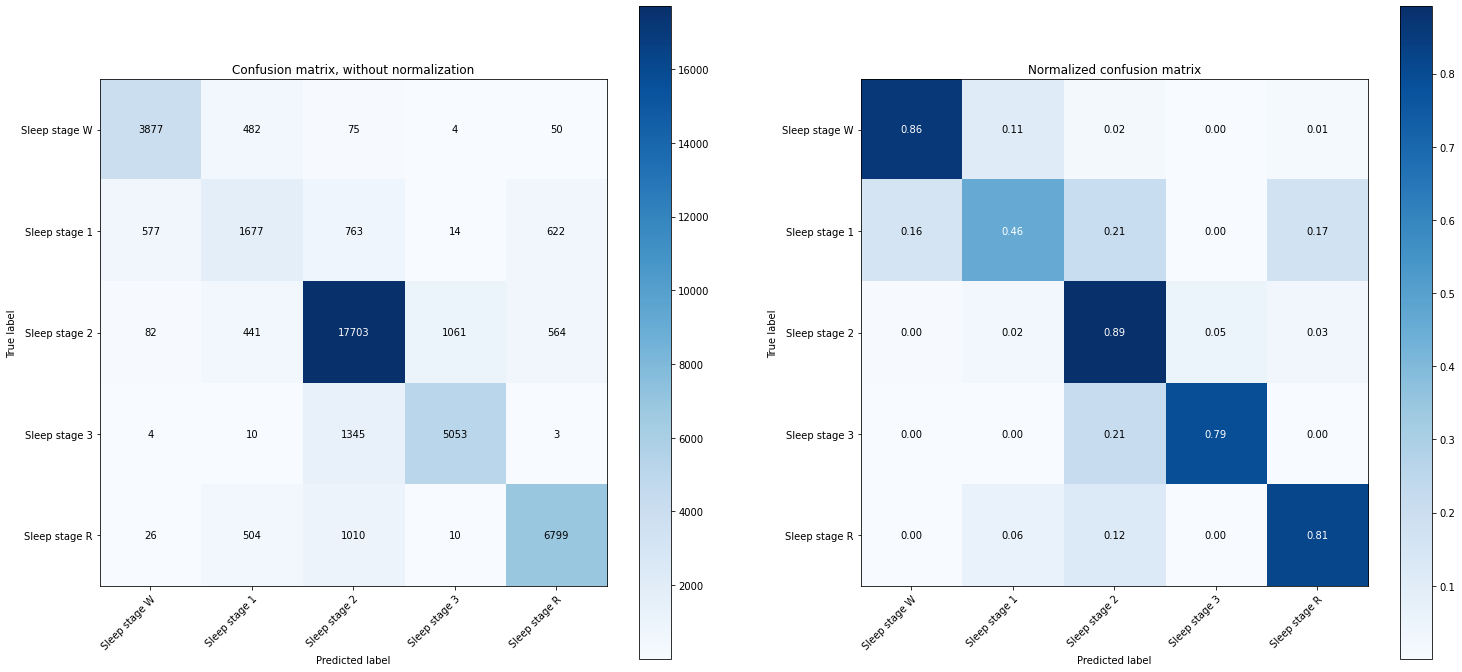





---------------------------------------- ['EEG', 'EOG'] ----------------------------------------
nb. features = 848
10-FOLD: TRAIN
  MACRO F1:           0.9292
  Balanced accuracy:  0.9195
  Accuracy:           0.9399
  Log loss:           0.1844
10-FOLD: TEST
  MACRO F1:           0.775
  Balanced accuracy:  0.7846
  Accuracy:           0.8319
  Log loss:           0.4536

F1: 0.7891170597319259
ACC: 0.8315791935634764
KAPPA: 0.7579340403053128
LOG LOSS: 0.4552656633290646

               precision    recall  f1-score   support

Sleep stage 1       0.52      0.61      0.56      3107
Sleep stage 2       0.90      0.84      0.87     21145
Sleep stage 3       0.78      0.81      0.79      6130
Sleep stage R       0.84      0.89      0.86      7824
Sleep stage W       0.87      0.85      0.86      4550

     accuracy                           0.83     42756
    macro avg       0.78      0.80      0.79     42756
 weighted avg       0.84      0.83      0.83     42756



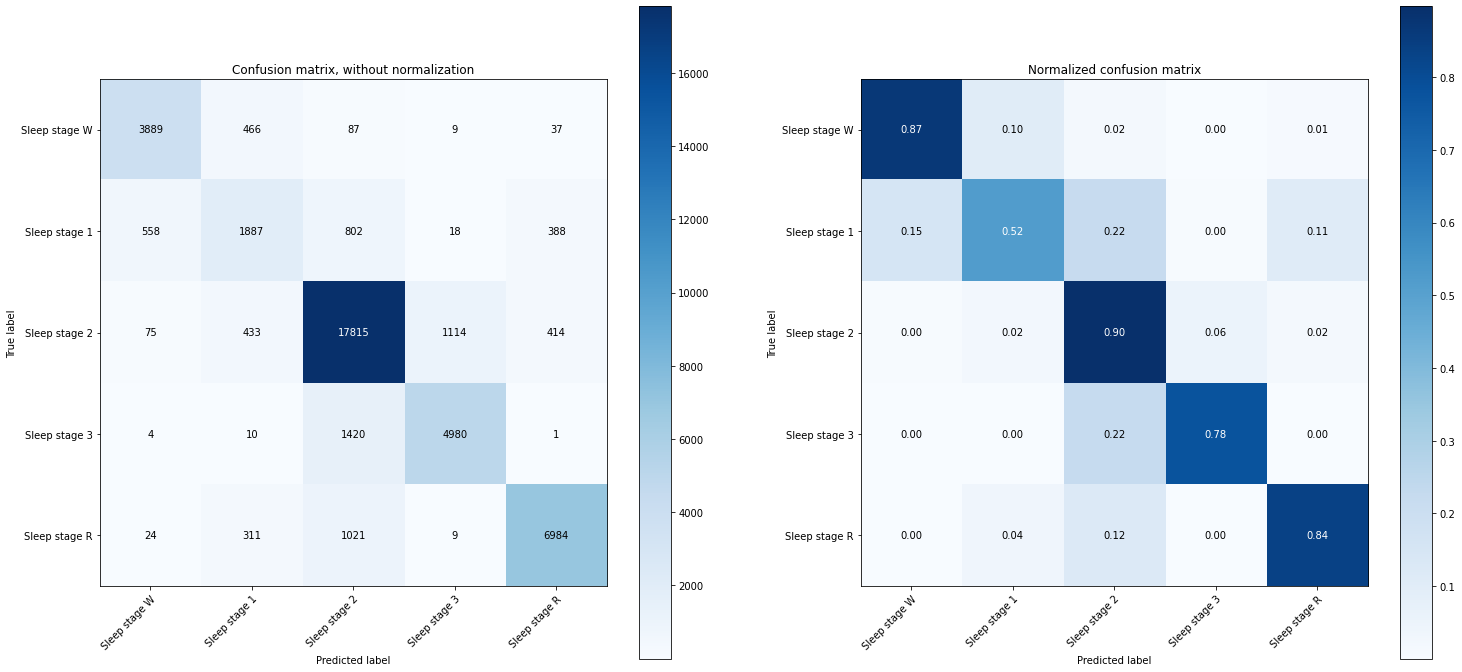





---------------------------------------- ['EEG', 'EMG'] ----------------------------------------
nb. features = 792
10-FOLD: TRAIN
  MACRO F1:           0.9309
  Balanced accuracy:  0.9216
  Accuracy:           0.9425
  Log loss:           0.1815
10-FOLD: TEST
  MACRO F1:           0.7689
  Balanced accuracy:  0.7798
  Accuracy:           0.8291
  Log loss:           0.4522

F1: 0.7840467170079737
ACC: 0.8285854616895875
KAPPA: 0.7547040098903721
LOG LOSS: 0.45358931618774784

               precision    recall  f1-score   support

Sleep stage 1       0.49      0.59      0.53      3015
Sleep stage 2       0.88      0.85      0.87     20647
Sleep stage 3       0.79      0.82      0.80      6170
Sleep stage R       0.86      0.86      0.86      8325
Sleep stage W       0.87      0.85      0.86      4599

     accuracy                           0.83     42756
    macro avg       0.78      0.79      0.78     42756
 weighted avg       0.84      0.83      0.83     42756



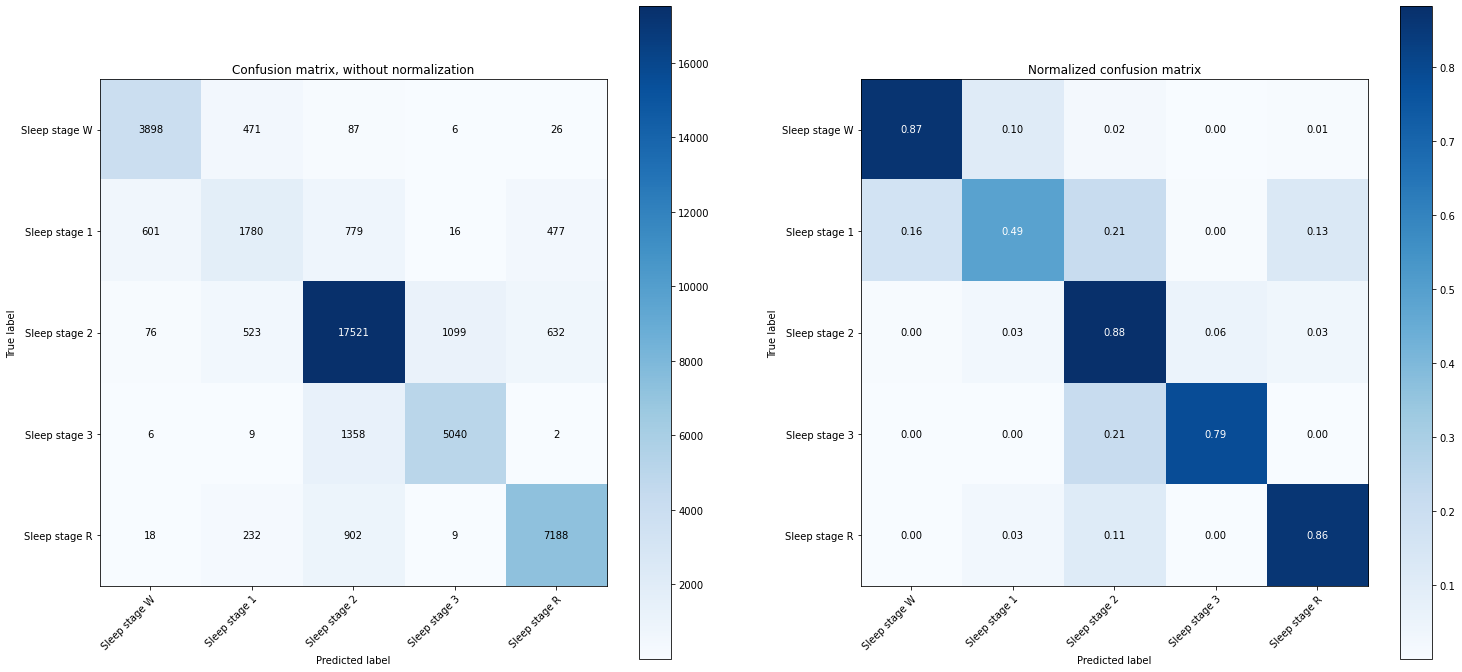

In [21]:
for inputs in [["EEG"], ["EEG", "EOG"], ["EEG", "EMG"]]:
    print("--" * 20, inputs, "--" * 20)

    feats_input = [f for f in feat_cols if f.split(" ")[0] in inputs]
    print("nb. features =", len(feats_input))

    ## Cross-validation
    # Total of 10 folds
    gkfold = StratifiedGroupKFold(n_splits=22)
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

    res = cross_validate(
        pipe,
        df_feats[feats_input],
        df_feats["label"],
        scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
        cv=cv,
        n_jobs=25,
        return_train_score=True,
        return_estimator=True,
    )

    print("10-FOLD: TRAIN")
    print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

    print("10-FOLD: TEST")
    print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
    print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
    print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
    print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

    preds = []
    preds_proba = []
    y_trues = []
    cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
    for fold_ix, (train_idx, test_idx) in enumerate(cv):
        X_train = df_feats[feats_input].iloc[train_idx]
        y_train = df_feats["label"].iloc[train_idx]
        X_test = df_feats[feats_input].iloc[test_idx]
        y_test = df_feats["label"].iloc[test_idx]
        
        estimator = res["estimator"][fold_ix]
        preds += [estimator.predict(X_test).ravel()]
        preds_proba += [estimator.predict_proba(X_test)]
        y_trues += [y_test]

    preds = np.hstack(preds)
    y_trues = np.hstack(y_trues)
    preds_proba = np.vstack(preds_proba)

    print()
    print("F1:", f1_score(preds, y_trues, average="macro"))
    print("ACC:", accuracy_score(preds, y_trues))
    print("KAPPA:", cohen_kappa_score(preds, y_trues))
    print("LOG LOSS:", log_loss(y_trues, preds_proba))
    print()

    print(classification_report(preds, y_trues))

    plt.figure(figsize=(25,12))
    ax = plt.subplot(1,2,1)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
    ax = plt.subplot(1,2,2)
    plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)
    plt.show()

    print("\n\n\n")